In [40]:
import pydicom as dicom
import matplotlib.pylab as plt
import os
import re
import numpy as np
import pandas as pd
from sklearn.naive_bayes import GaussianNB
from PIL import Image, ImageFilter
import PIL

In [47]:
image_path = 'ImagenesBuenas\\'
image_save_path = 'img_filter\\'
#Abrir archivo de imagen
def abrirImagen(img):s
    return Image.open(image_save_path+img) #Se abre la imagen con la bilbioteca PIL

#Redimensinar imagen de 3D a 2D
def redimensionarImagen(arr):
    arr = arr.reshape((arr.shape[0]*arr.shape[1],arr.shape[2])) #Converimos la matriz de 3D a 2D (col*row,canal)
    arr = arr[~np.all(arr == 0, axis=1)] # Se eliminan todos los 0's de la matriz
    arr = np.delete(arr ,np.where((arr[:,3] != 255))[0], axis=0) #Eliminamos el canal alfa de la imagen
    return arr #Regresamos la imagen a 2D sin canal alfa

In [32]:
for i in range(16):    #For para recorrer las 16 imagenes
    ds = dicom.dcmread(image_path + 'imagen' + str(i+1) + '.dcm')    #Lectura de imagen formato dcm
    image = ds.pixel_array
    plt.imsave(image_save_path + 'imagen'+ str(i+1) +'.jpg',image,cmap=plt.cm.gray) #Cambiamos a escala de grises y a formato jpg

In [60]:
def crearFeature(nombre,clase): #Creando data frame por cada clase
    imagenes = os.listdir('img_filter\\') #Obtener los nombres del ls archivos en la carpeta comida
    arr_mask = np.array([[]]) #Crear un arreglo vacio donde guardamos toda la información de las mascaras
    arr_mask = np.resize(arr_mask,(0,3)) #Redimensinar el arreglo para que tenga las columnas R G B

    for mask in imagenes: #Iterar sobre las imagenes
        if re.match(r"^"+nombre,mask):  # Condicional para buscar imagenes con el nombre de las mascara dada
            imagen = abrirImagen(mask)  # Abrir la imagen de la mascara
            imagen = np.array(imagen) # Convertir la imagen en un arreglo 
            imagen = redimensionarImagen(imagen) # Redimensionar la imagen para tener las columnas R G B
            imagen = np.delete(imagen,3,1) # Eliminar la ultima columna del arreglo (canal alpha)
            arr_mask = np.concatenate((arr_mask, imagen), axis=0) #Concatenar los arreglos 

    df = pd.DataFrame(arr_mask,columns=["R","G","B"]) # Convertir el arreglo en un Data Frame
    df["Clase"] = clase # Poner nombre de la clase al data frame
    return df #Regresar el data frame

In [86]:
def clasificador_skitlearn(df_train,test):
    y_train = df_train["Clase"] # Crear data frame Y de entrenamiendo (Salidas)
    x_train = df_train.drop("Clase", axis = 1) # Crear data frame X de entrenamiendo (Entradas)
    df_test = pd.DataFrame(test,columns=["R","G","B"]) # Crear data frame de prueba

    clf = GaussianNB() # Clasificador de bayes
    clf.fit(x_train, y_train) # Entrar modelo de datos de entrenamiento
    SkTest = clf.predict(df_test) # Predecir con los datos de prueba

    r = pd.DataFrame(SkTest,columns=["Clase"]) # Crear data frame apartir de los datos de prueba

    conditions = [(r["Clase"] == "0"),   
                    (r["Clase"] == "1"),
                    (r["Clase"] == "2"),
                    (r["Clase"] == "3")
                   ] # Condiciones para asignar un valor dependiendo de la clase 

    values = [242,175,81,0] #Valores (colores) que se asignan dependiendo de la clase
    r["R"] = np.select(conditions, values) # Agregar la columna R al data frame de salida
    r["G"] = np.select(conditions, values) # Agregar la columna G al data frame de salida
    r["B"] = np.select(conditions, values) # Agregar la columna B al data frame de salida

    r = r.drop("Clase", axis = 1) # Eliminar la columna de clase

    arr = r.to_numpy() # Convertir el data frame en un arrglo
    arr = arr.reshape(767,803,3) # Redimensionar el arreglo como formato de imagen para poder desplegarla
    arr = Image.fromarray(arr.astype(np.uint8)) # Converir el arreglo a una imagen dado un arreglo
    print("---  Imagen creada con el clasificador bayesiano de SKlearn--- ")
    display(arr) # Mostrar la imgen creada con el clasificador bayesiano

In [90]:
# Ejemplo con muchos datos de las mascaras
df_izq = crearFeature("mask_izq","0") #Data frame de datos para la clase de ventriculo izquierdo
df_der = crearFeature("mask_der","1") #Data frame de datos para la clase de ventriculo derecho
df_pared = crearFeature("mask_pared","2") #Data frame de datos para la clase de la pared
df_fondo = crearFeature("mask_fondo","3") #Data frame de datos para la clase de Fondo

df_train = pd.concat([df_izq,df_der,df_pared,df_fondo]) #Unir todos los dataframes y crear el data frame de entrenamiento

---  Imagen creada con el clasificador bayesiano de SKlearn--- 


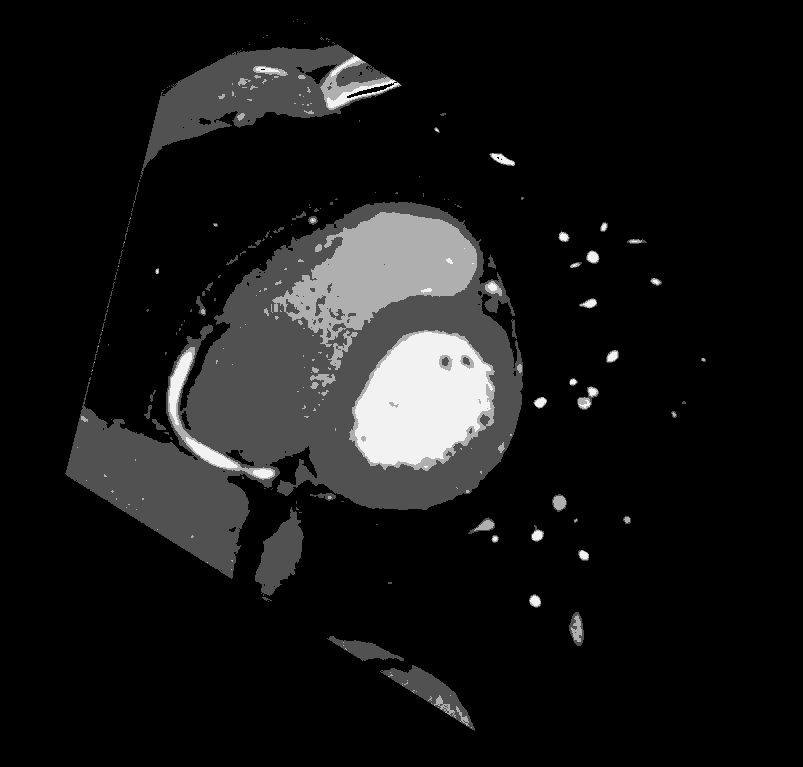

In [91]:
test = abrirImagen("imagen7.jpg") #Abrir la imagen de prueba
test = np.array(test) #Convertir la imagen a un arreglo
test = np.reshape(test, (-1, 3)) #Redimensior el arreglo para tener Cols Rows Canal 

clasificador_skitlearn(df_train,test) # Inicar prueba